In [1]:
import dataclasses

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [2]:
@dataclasses.dataclass
class Data:
    train: pd.DataFrame
    test: pd.DataFrame

In [3]:
FILES = ('discounts_train_scored.parq.gzip', 'discounts_test_scored.parq.gzip')

sns.set_style("darkgrid")
pd.options.display.max_columns = 100

In [5]:
data = Data(pd.read_parquet(FILES[0]), pd.read_parquet(FILES[1]))
data.test.head()

,spend_1m_baby,spend_2m_baby,spend_3m_baby,spend_4m_baby,spend_5m_baby,spend_6m_baby,spend_1m_clothes,spend_2m_clothes,spend_3m_clothes,spend_4m_clothes,spend_5m_clothes,spend_6m_clothes,spend_1m_health,spend_2m_health,spend_3m_health,spend_4m_health,spend_5m_health,spend_6m_health,spend_1m_pet,spend_2m_pet,spend_3m_pet,spend_4m_pet,spend_5m_pet,spend_6m_pet,spend_1m_groceries,spend_2m_groceries,spend_3m_groceries,spend_4m_groceries,spend_5m_groceries,spend_6m_groceries,spend_1m_eletronic,spend_2m_eletronic,spend_3m_eletronic,spend_4m_eletronic,spend_5m_eletronic,spend_6m_eletronic,sales,discount,age,gender,cust_state,tenure,profit,sales_prediction
0,0,0,0,0,0,0.0,25,50.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,1503.22,20.0,35,1.0,MA,23,55.16,2292.466177
1,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,10,10,5.0,5.0,0.0,0.0,0,0,0,0.0,0.0,0.0,1798.30,60.0,29,1.0,MG,18,29.92,1734.958214
2,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,1122.97,0.0,30,1.0,RJ,20,56.15,1855.784629
3,10,15,0,25,10,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,15,25,95.0,10.0,0.0,0.0,0,0,0,0.0,0.0,0.0,1217.08,10.0,32,0.0,BA,20,50.85,2236.858599
4,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,966.58,0.0,30,0.0,PB,22,48.33,1667.244759


In [7]:
data.test['is_treated'] = (data.test['discount'] > 30).astype(int)

In [9]:
def te(data, treat_col, outcome_col):
    mask = data[treat_col] == 1
    return data.loc[mask, outcome_col].mean() - data.loc[~mask, outcome_col].mean()

In [24]:
te(data.test, 'is_treated', 'profit')

-7.955100647304356

In [80]:
def effect_by_segment(data, segment_col, q=5):
    quantiles = pd.qcut(data[segment_col], q=q, labels=False, retbins=False, duplicates='drop')
    return data.assign(segment=quantiles) \
                .groupby(['segment']) \
                .apply(lambda grp: te(grp, 'is_treated', 'profit')) \
                .reset_index(name='treatment_effect')

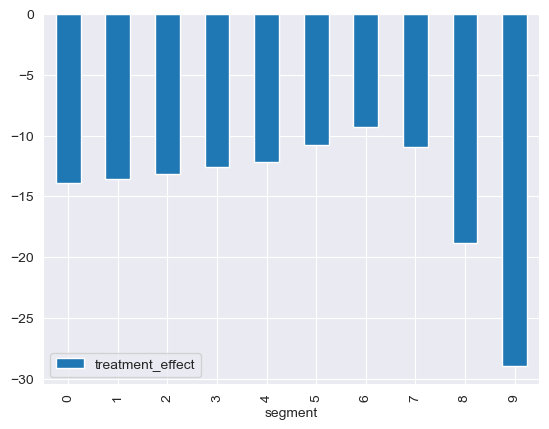

In [81]:
effect_by_segment(data.test, 'sales_prediction', q=10).plot(kind='bar', x='segment')
plt.show()

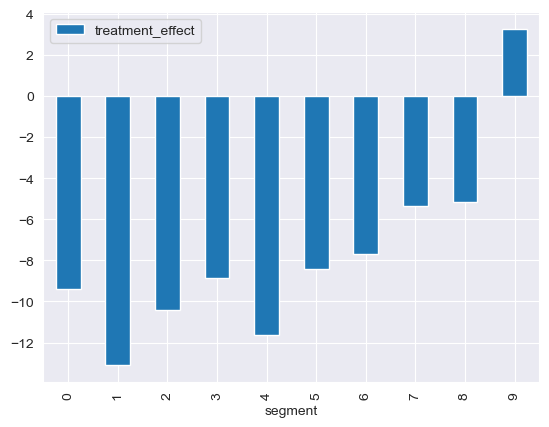

In [83]:
effect_by_segment(data.test, 'age', q=10).plot(kind='bar', x='segment')
plt.show()

In [151]:
def cumulative_effect_curve(data, order_by, ascending=False):
    ordered = data.sort_values(order_by, ascending=ascending)
    percentiles = np.arange(0., 1., .01)
    edges = [data[order_by].quantile(x) for x in percentiles]
    res = [
        te(ordered.query(f'{order_by} >= {e}'), 'is_treated', 'profit')
        for e in edges[::-1]
    ]
    sns.lineplot(x=percentiles, y=res)
    plt.ylabel('Cumulative Treatment Effect')
    plt.xlabel('% of Customers')
    plt.title('Cumulative Effect Curve')
    plt.show()

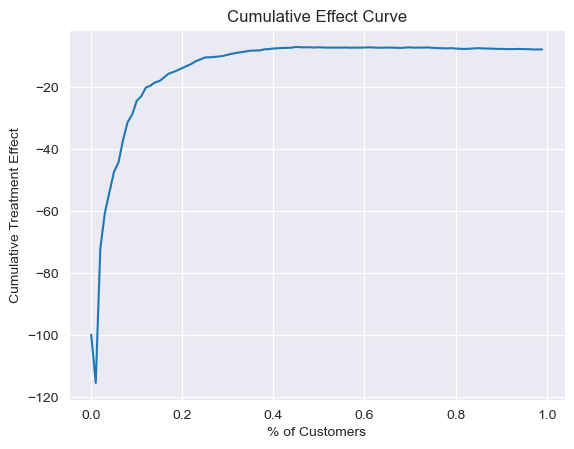

In [152]:
cumulative_effect_curve(data.test, 'sales_prediction')

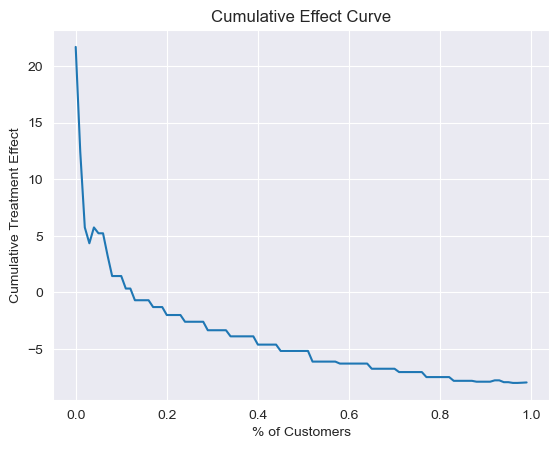

In [153]:
cumulative_effect_curve(data.test, 'age')

In [186]:
def cumulative_gain(data, order_by, ascending=False):
    ordered = data.sort_values(order_by, ascending=ascending)
    percentiles = np.arange(0., 1., .1)
    edges = [data[order_by].quantile(x) for x in percentiles]
    res = [
        te(ordered.query(f'{order_by} >= {e}'), 'is_treated', 'profit') * p
        for e,p in zip(edges[::-1], percentiles)
    ]
    sns.lineplot(x=percentiles, y=res, label=order_by)
    plt.ylabel('Cumulative Gain')
    plt.xlabel('% of Customers')
    plt.title('Cumulative Gain Curve')
    plt.axline((0, 0), (1, te(data, 'is_treated', 'profit')), color='black', linestyle='dotted', alpha=.25)
    # plt.show()

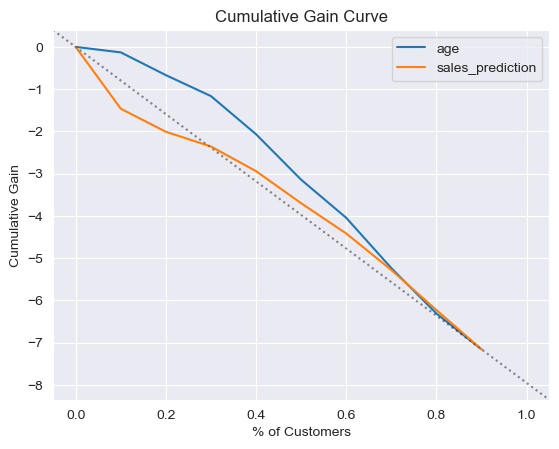

In [187]:
cumulative_gain(data.test, 'age')
cumulative_gain(data.test, 'sales_prediction')
plt.show()